# SBERT Fine-Tuning on TIP with Primary SDG Labels


In [47]:
# Install specific GPU-compatible versions of torch/torchaudio for CUDA
!pip uninstall -y torch torchaudio torchvision
!pip install torch==2.5.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu128

# Install dependencies for Hugging Face Trainer + SBERT
!pip install -U accelerate sentence-transformers datasets

!pip install -U sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: torch 2.7.0
Uninstalling torch-2.7.0:
  Successfully uninstalled torch-2.7.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/cu128
ERROR: Could not find a version that satisfies the requirement torch==2.5.1 (from versions: 2.7.0+cu128)
ERROR: No matching distribution found for torch==2.5.1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached torch-2.7.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (29 kB)
Using cached torch-2.7.0-cp312-cp312-manylinux_2_28_x86_64.whl (865.0 MB)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [63]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Built with CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected by PyTorch.")

Torch version: 2.7.0+cu126
CUDA available: False
Built with CUDA version: 12.6
No GPU detected by PyTorch.


In [64]:
import pandas as pd

df = pd.read_csv("osdg-community-data-v2024-04-01.csv", sep="\t")
print("Dataset loaded with shape:", df.shape)
print("Columns:", df.columns.tolist())

# Drop incomplete rows
df = df.dropna(subset=['text', 'sdg'])
df['sdg'] = df['sdg'].astype(float)

# Log labels_positive for later multi-label use
df['labels_positive'] = df['labels_positive'].astype(str)
df.head()

Dataset loaded with shape: (10419, 7)
Columns: ['doi', 'text_id', 'text', 'sdg', 'labels_negative', 'labels_positive', 'agreement']


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5.0,1.0,8.0,0.777778
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11.0,2.0,1.0,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3.0,1.0,8.0,0.777778
3,10.1787/3726edff-en,0005d3e8b213d9e2cb967666e1aca2e9,Applied research is directed “primarily toward...,9.0,3.0,6.0,0.333333
4,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3.0,1.0,2.0,0.333333


In [65]:
# 1. Imports
from datasets import Dataset
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import os

In [66]:
# 2. Load and clean the dataset
df = pd.read_csv("osdg-community-data-v2024-04-01.csv", sep="\t")
df = df.dropna(subset=['text', 'sdg'])
df['sdg'] = df['sdg'].astype(int)


In [67]:
# 3. Encode labels
unique_labels = sorted(df['sdg'].unique())  # This is correct
label2id = {label: idx for idx, label in enumerate(unique_labels)}  # SDG -> model label ID
id2label = {v: k for k, v in label2id.items()}  # model label ID -> SDG

df['label_id'] = df['sdg'].map(label2id)


In [68]:
print("Label2ID mapping:", label2id)
print("Total labels:", len(label2id))

Label2ID mapping: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(6): 5, np.int64(7): 6, np.int64(8): 7, np.int64(9): 8, np.int64(10): 9, np.int64(11): 10, np.int64(12): 11, np.int64(13): 12, np.int64(14): 13, np.int64(15): 14, np.int64(16): 15}
Total labels: 16


In [69]:
# 4. Split into train and eval
train_df, eval_df = train_test_split(df, test_size=0.1, random_state=42)

# Provide two identical sentences per InputExample for SoftmaxLoss
train_samples = [
    InputExample(texts=[row['text'], row['text']], label=row['label_id'])
    for _, row in train_df.iterrows()
]
eval_samples = [
    InputExample(texts=[row['text'], row['text']], label=row['label_id'])
    for _, row in eval_df.iterrows()
]

In [70]:
from sentence_transformers import InputExample

print("\nSample training example:")
print(train_samples[0])  # Should show InputExample(texts=[...], label=...)


Sample training example:
<InputExample> label: 6, texts: Moreover, the energy integration process is not limited simply to creation of physical links across the region. It requires a series of policies and regulations for facilitating different types of flows inherent in this process. This requires intervention and leadership by the member governments and technical experts if regional energy connectivity is to happen. To a great extent, this demonstrates die lack of human and institutional capabilities, political leadership, and market mechanisms.; Moreover, the energy integration process is not limited simply to creation of physical links across the region. It requires a series of policies and regulations for facilitating different types of flows inherent in this process. This requires intervention and leadership by the member governments and technical experts if regional energy connectivity is to happen. To a great extent, this demonstrates die lack of human and institutional capabi

In [71]:
# 5. DataLoaders
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(eval_samples, shuffle=False, batch_size=16)

In [72]:
from sentence_transformers import SentenceTransformer, losses
import torch.nn as nn
import torch

class CustomSoftmaxLoss(losses.SoftmaxLoss):
    def forward(self, sentence_features, labels):
        reps = [self.model(sentence_feature)['sentence_embedding'] for sentence_feature in sentence_features]

        rep_a, rep_b = reps
        vectors_concat = [rep_a, rep_b, torch.abs(rep_a - rep_b), rep_a * rep_b]  # Include 4 components
        features = torch.cat(vectors_concat, dim=1)

        output = self.classifier(features)

        if labels is not None:
            loss = self.loss_fct(output, labels.view(-1))
            return loss
        else:
            return None, output  # <-- Fix: return prediction properly for evaluator

In [73]:
# 6. Define SBERT model
from sentence_transformers import SentenceTransformer, losses, models
from sentence_transformers.evaluation import LabelAccuracyEvaluator

# Load base model
word_embedding_model = models.Transformer('sentence-transformers/all-MiniLM-L6-v2')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Define loss using built-in SoftmaxLoss
train_loss = CustomSoftmaxLoss(
    model=model,
    sentence_embedding_dimension=pooling_model.get_sentence_embedding_dimension(),
    num_labels=len(label2id)
)

# Fix: Update classifier input shape
train_loss.classifier = torch.nn.Linear(
    pooling_model.get_sentence_embedding_dimension() * 4,
    len(label2id)
)

evaluator = LabelAccuracyEvaluator(eval_dataloader, name='sdg_eval')
evaluator.softmax_model = train_loss

In [74]:
print(type(model))
print("\nEmbedding dimension for softmax loss:")
print("Expected:", pooling_model.get_sentence_embedding_dimension())
print("Expected input dim for classifier:", pooling_model.get_sentence_embedding_dimension() * 4)
print("Actual classifier weight shape:", train_loss.classifier.weight.shape)

<class 'sentence_transformers.SentenceTransformer.SentenceTransformer'>

Embedding dimension for softmax loss:
Expected: 384
Expected input dim for classifier: 1536
Actual classifier weight shape: torch.Size([16, 1536])


In [75]:
print("\nVerifying evaluator setup:")
print("Type of evaluator:", type(evaluator))
print("Evaluator has softmax_model?", hasattr(evaluator, 'softmax_model'))
print("Type of softmax_model:", type(evaluator.softmax_model))
print("softmax_model is None?", evaluator.softmax_model is None)

# Optional: check internal classifier layer
if hasattr(evaluator.softmax_model, 'classifier'):
    print("Classifier layer of softmax_model:", evaluator.softmax_model.classifier)


Verifying evaluator setup:
Type of evaluator: <class 'sentence_transformers.evaluation.LabelAccuracyEvaluator.LabelAccuracyEvaluator'>
Evaluator has softmax_model? True
Type of softmax_model: <class '__main__.CustomSoftmaxLoss'>
softmax_model is None? False
Classifier layer of softmax_model: Linear(in_features=1536, out_features=16, bias=True)


In [76]:
# 8. Output path
output_path = "./output-sdg-softmax"
os.makedirs(output_path, exist_ok=True)

In [77]:
# Dummy input for feature shape validation
import torch

correct_input_dim = train_loss.classifier.in_features
sample_input = torch.rand(1, correct_input_dim)

output = train_loss.classifier(sample_input)

print("Classifier output shape:", output.shape)

Classifier output shape: torch.Size([1, 16])


In [78]:
# 9. Train
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=1,  # Increase if needed
    evaluation_steps=1000,
    output_path=output_path,
    warmup_steps=100
)

# Fine Tuning done!

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Sdg Eval Accuracy
586,1.674300,No log,0.713052


In [79]:
def predict_sdg(sent1, sent2, model, classifier, id2label):
    features = [model.tokenize([s]) for s in [sent1, sent2]]
    with torch.no_grad():
        reps = [model(feat)["sentence_embedding"] for feat in features]
        rep_a, rep_b = reps
        combined = torch.cat([rep_a, rep_b, torch.abs(rep_a - rep_b), rep_a * rep_b], dim=1)
        logits = classifier(combined)
        pred_id = torch.argmax(logits, dim=1).item()
        return pred_id, id2label[pred_id]

In [80]:
sdg_names = {
    1: "No Poverty", 2: "Zero Hunger", 3: "Good Health and Well-being",
    4: "Quality Education", 5: "Gender Equality", 6: "Clean Water and Sanitation",
    7: "Affordable and Clean Energy", 8: "Decent Work and Economic Growth",
    9: "Industry, Innovation and Infrastructure", 10: "Reduced Inequality",
    11: "Sustainable Cities and Communities", 12: "Responsible Consumption and Production",
    13: "Climate Action", 14: "Life Below Water", 15: "Life on Land", 16: "Peace, Justice and Strong Institutions"
}


In [83]:
example1 = (
    "Carbon emissions are rising due to increased fossil fuel use.",
    "Urgent action is needed to combat climate change."
)

pred_id, sdg_number = predict_sdg(*example1, model, train_loss.classifier, id2label)
print("Predicted SDG Label ID:", pred_id)
print("Predicted SDG Number:", sdg_number)
print("SDG Name:", sdg_names[sdg_number])

Predicted SDG Label ID: 6
Predicted SDG Number: 7
SDG Name: Affordable and Clean Energy


In [84]:
# Example: Infrastructure and sustainable cities
sent1 = "Urban transportation systems need to be upgraded to support growing populations."
sent2 = "Sustainable infrastructure is key to building inclusive and resilient cities."

pred_id, sdg_number = predict_sdg(sent1, sent2, model, train_loss.classifier, id2label)
print("Predicted SDG Label ID:", pred_id)
print("Predicted SDG Number:", sdg_number)
print("SDG Name:", sdg_names[sdg_number])

Predicted SDG Label ID: 10
Predicted SDG Number: 11
SDG Name: Sustainable Cities and Communities


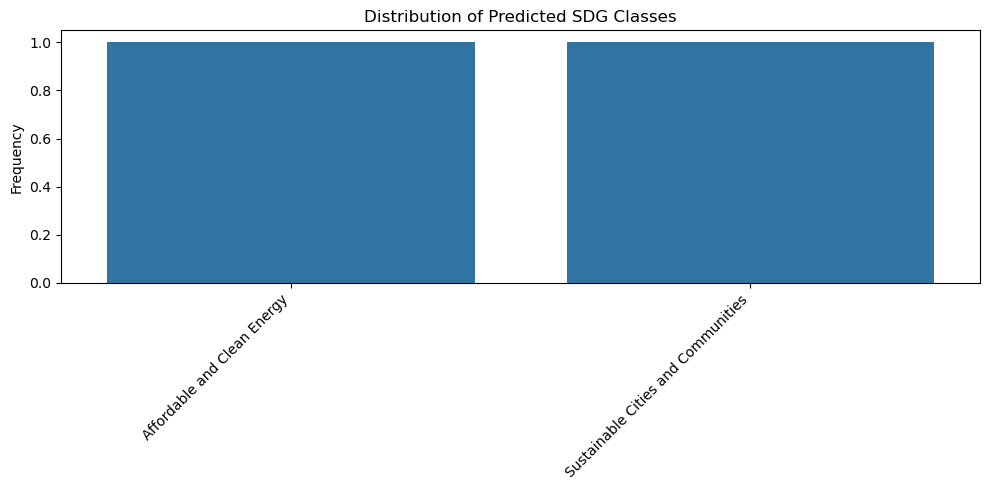

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose you collect results like this:
predicted_labels = [7, 11]  # Predicted SDG numbers

# Optional: Convert to names
predicted_names = [sdg_names[label] for label in predicted_labels]

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(x=predicted_names, order=sorted(set(predicted_names)))
plt.title("Distribution of Predicted SDG Classes")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()